In [1]:
import pandas as pd
import numpy as np
from speedml import Speedml
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import ftfy
import re
import collections
from gensim import corpora, models, similarities
import warnings
warnings.filterwarnings("ignore")

unable to import 'smart_open.gcs', disabling that module


In [2]:
df = pd.read_csv('../data/raw/senators.csv')

In [3]:
df.head()

,created_at,text,url,replies,retweets,favorites,user,bioguide_id,party,state
0,10/19/17 21:47,We released bipartisan healthcare bill today &...,https://twitter.com/amyklobuchar/status/921130...,21,129,533,amyklobuchar,K000367,D,MN
1,10/19/17 18:48,I spoke with @Morning_Joe team abt #HonestAds ...,https://twitter.com/amyklobuchar/status/921085...,8,46,150,amyklobuchar,K000367,D,MN
2,10/19/17 18:14,Lots of interest in my bill with Senators Warn...,https://twitter.com/amyklobuchar/status/921077...,36,227,932,amyklobuchar,K000367,D,MN
3,10/19/17 18:04,"Today's the day @MarkWarner, @SenJohnMcCain &a...",https://twitter.com/amyklobuchar/status/921074...,17,167,550,amyklobuchar,K000367,D,MN
4,10/19/17 16:33,".@MarkWarner, @SenJohnMcCain &amp; I put toget...",https://twitter.com/amyklobuchar/status/921051...,31,279,893,amyklobuchar,K000367,D,MN


In [4]:
userdf = df.groupby('user').sum().sort_values('favorites',ascending=False)
userdf

,replies,retweets,favorites
user,,,
SenSanders,1364136,15144944,39910303
SenWarren,773983,4978416,13446122
SenatorLeahy,339683,4589443,12381645
SenSchumer,733255,3446210,7456072
timkaine,448106,2799204,7256570
...,...,...,...
InhofePress,9879,43185,25185
SenDanSullivan,7415,13260,24647
SenJohnHoeven,5536,13112,22009


In [5]:
df1 = df.groupby('user').agg({'replies':'size','favorites':'nunique'})
df1['result_col'] = df1['replies'].div(df1['favorites'])

In [6]:
df1

,replies,favorites,result_col
user,,,
BillCassidy,3199,193,16.575130
ChrisCoons,3244,286,11.342657
ChrisVanHollen,3101,483,6.420290
ChuckGrassley,3237,287,11.278746
InhofePress,3211,76,42.250000
...,...,...,...
maziehirono,3224,373,8.643432
sendavidperdue,2618,199,13.155779
senorrinhatch,3204,397,8.070529


# Preprocessing

In [7]:
df['Clean text'] = df['text'].apply(lambda x: ftfy.fix_text(x))

In [8]:
# Find the hashtags and people mentioned
def find_mentioned(tweet):
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for mentioned usernames and hashtags
df['mentioned'] = df['Clean text'].apply(find_mentioned)
df['hashtags'] = df['Clean text'].apply(find_hashtags)

In [9]:
# Clean up text
# df['Clean text'] = df['Clean text'].str.replace('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', case=False)
# df['Clean text'] = df['Clean text'].str.replace('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', case=False)
df['Clean text'] = df['Clean text'].str.replace('http\S+|www.\S+',', ''', case=False)

# EDA

In [10]:
# Retweets by political party

dfparty = df.groupby('party').sum()

dtotal = df[df['party']=='D']['party'].count()
rtotal = df[df['party']=='R']['party'].count()
itotal = df[df['party']=='I']['party'].count()

dfparty['Total Tweets'] = 0
dfparty['Reply ratio'] = 0
dfparty['Retweet ratio'] = 0
dfparty['Positive Engagement'] = 0
dfparty['Negative Engagement'] = 0


dfparty.loc['D']['Total Tweets'] = dtotal
dfparty.loc['I']['Total Tweets'] = itotal
dfparty.loc['R']['Total Tweets'] = rtotal


dfparty.loc['D']['Reply ratio'] = dfparty.loc['D']['replies']/dtotal
dfparty.loc['D']['Retweet ratio'] = dfparty.loc['D']['retweets']/dtotal
dfparty.loc['D']['Positive Engagement'] = dfparty.loc['D']['favorites']/dtotal
dfparty.loc['D']['Negative Engagement'] = dfparty.loc['D']['replies']/dfparty.loc['D']['retweets']*100


dfparty.loc['I']['Reply ratio'] = dfparty.loc['I']['replies']/dtotal
dfparty.loc['I']['Retweet ratio'] = dfparty.loc['I']['retweets']/dtotal
dfparty.loc['I']['Positive Engagement'] = dfparty.loc['I']['favorites']/dtotal
dfparty.loc['I']['Negative Engagement'] = dfparty.loc['I']['replies']/dfparty.loc['I']['retweets']*100

dfparty.loc['R']['Reply ratio'] = dfparty.loc['R']['replies']/dtotal
dfparty.loc['R']['Retweet ratio'] = dfparty.loc['R']['retweets']/dtotal
dfparty.loc['R']['Positive Engagement'] = dfparty.loc['R']['favorites']/dtotal
dfparty.loc['R']['Negative Engagement'] = dfparty.loc['R']['replies']/dfparty.loc['R']['retweets']*100



dfparty


,replies,retweets,favorites,Total Tweets,Reply ratio,Retweet ratio,Positive Engagement,Negative Engagement
party,,,,,,,,
D,5329723,45203541,100601212,136082,39,332,739,11
I,1376704,15183455,40006616,6255,10,111,293,9
R,5387049,11468965,28647658,146278,39,84,210,46


# Observations

Democratic and Republican tweets have a similar reply ratio, however, the retweet and favorite ratio is much higher for the Democratic tweets.

In [11]:
# Finding the most common hashtags
hashtaglist = []
for i, row in df.iterrows():
    if len(row['hashtags'])>0:
        for i in row['hashtags']:
            hashtaglist.append(i)
hashtagdict = collections.Counter(hashtaglist)
hashtagdict.most_common()[1:10]

[('#Trumpcare', 2099),
 ('#SCOTUS', 1737),
 ('#utpol', 1625),
 ('#mepolitics', 1439),
 ('#idpol', 1344),
 ('#mtpol', 1273),
 ('#ACA', 1220),
 ('#WV', 1140),
 ('#veterans', 1049)]

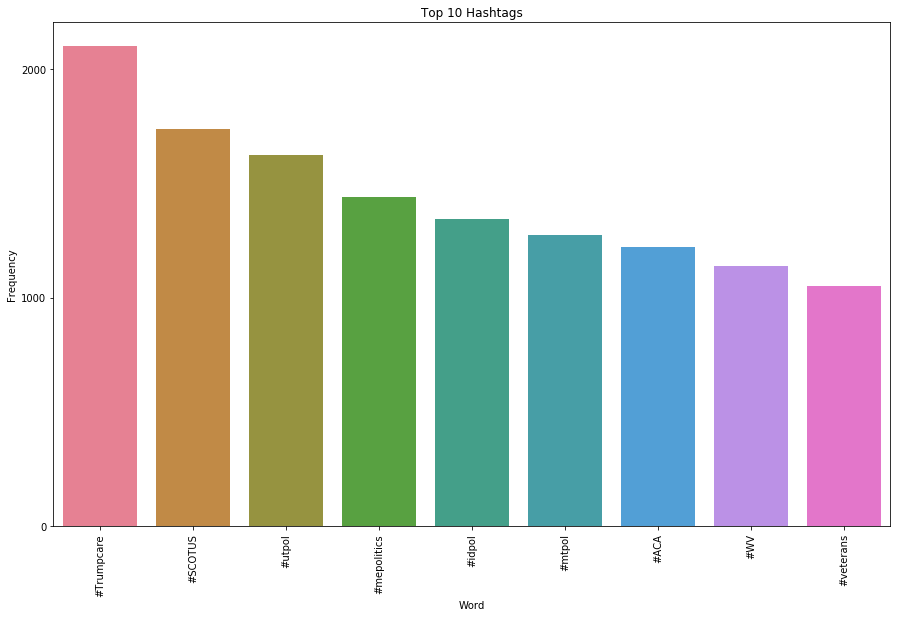

In [20]:
topwords = hashtagdict.most_common()[1:10]
words = [w[0] for w in topwords]
counts = [w[1] for w in topwords]
x_pos = np.arange(len(words))

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='Top 10 Hashtags')
sns.set_context("notebook", font_scale=5, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='husl')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Top hashtags by politial party

dhashtags = []
rhashtags  = []
for i, row in df.iterrows():
    if len(row['hashtags'])>0:
        if row['party'] == 'D':
            for i in row['hashtags']:
                dhashtags.append(i)
        else:
            for i in row['hashtags']:
                rhashtags.append(i)
                
dhashtags = collections.Counter(dhashtags)
rhashtags = collections.Counter(rhashtags)

print("Most common Democratic hashtags: ", dhashtags.most_common()[1:10])
print("Most common Republican hashtags: ", rhashtags.most_common()[1:10])

Most common Democratic hashtags:  [('#mtpol', 1172), ('#ACA', 1119), ('#SCOTUS', 929), ('#WV', 873), ('#DoYourJob', 790), ('#TrumpCare', 721), ('#Medicaid', 683), ('#GrahamCassidy', 592), ('#ActOnClimate', 586)]
Most common Republican hashtags:  [('#utpol', 1625), ('#mepolitics', 1438), ('#idpol', 1343), ('#SCOTUS', 808), ('#Iran', 779), ('#Kentucky', 742), ('#Senate', 733), ('#Ohio', 714), ('#IranDeal', 678)]


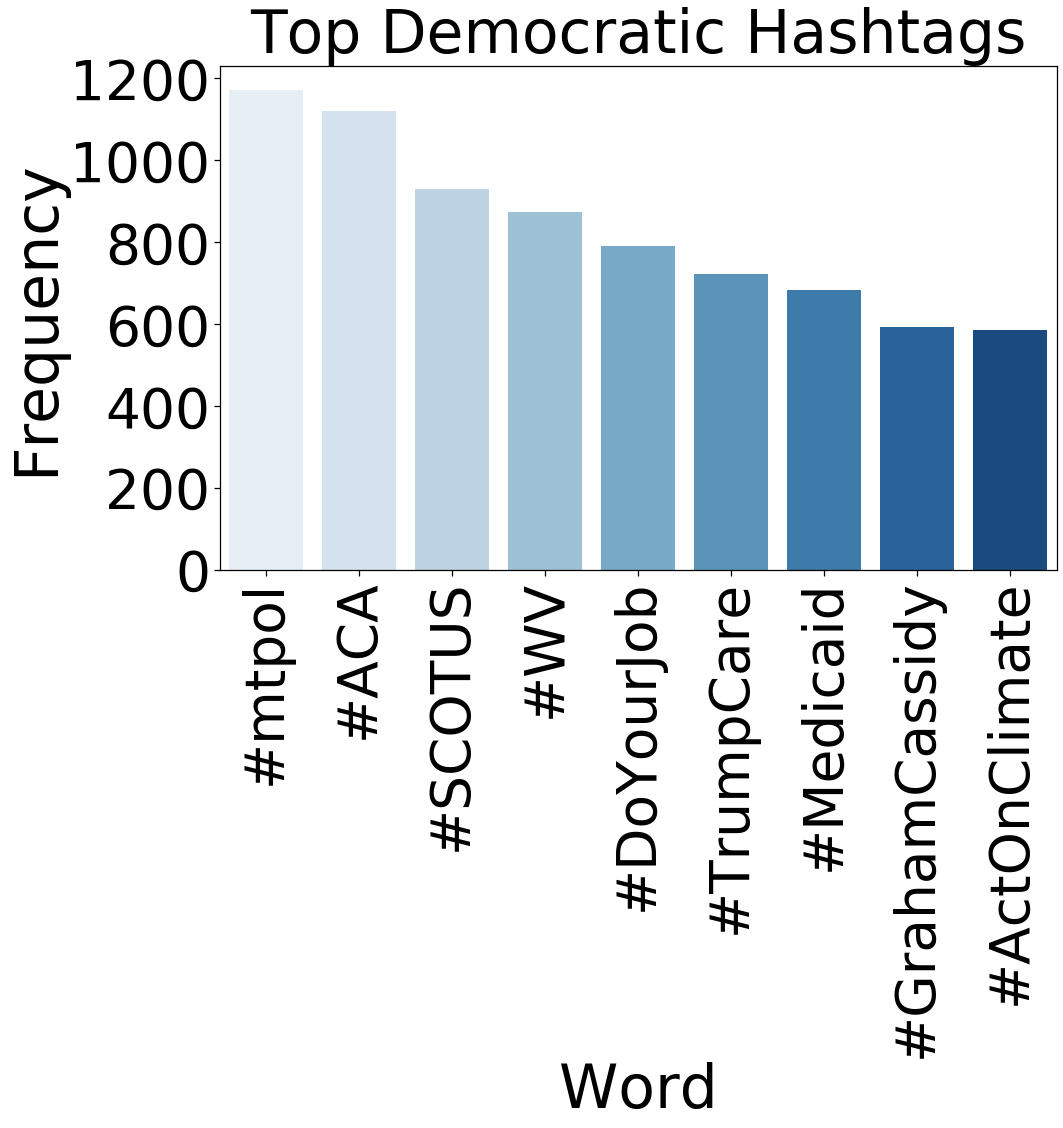

In [22]:
topwords = dhashtags.most_common()[1:10]
words = [w[0] for w in topwords]
counts = [w[1] for w in topwords]
x_pos = np.arange(len(words))

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='Top Democratic Hashtags')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='Blues')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

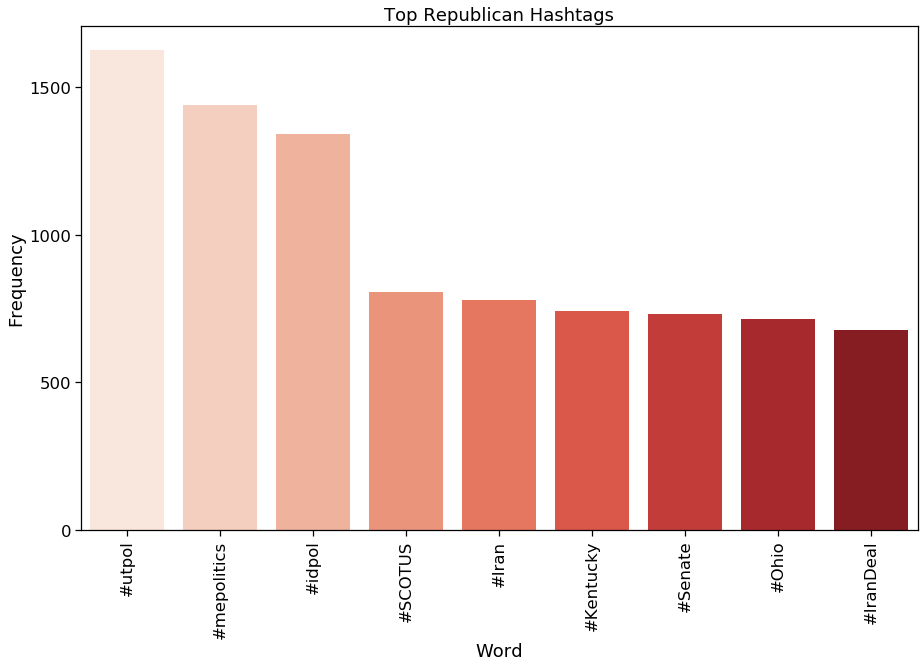

In [23]:
topwords = rhashtags.most_common()[1:10]
words = [w[0] for w in topwords]
counts = [w[1] for w in topwords]
x_pos = np.arange(len(words))

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='Top Republican Hashtags')
sns.set_context("notebook", font_scale=5, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='Reds')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Top mentioned by politial party

dmentioned = []
rmentioned  = []
for i, row in df.iterrows():
    if len(row['mentioned'])>0:
        if row['party'] == 'D':
            for i in row['mentioned']:
                dmentioned.append(i)
        else:
            for i in row['mentioned']:
                rmentioned.append(i)
                
dmentioned = collections.Counter(dmentioned)
rmentioned = collections.Counter(rmentioned)

print("Most common Democratic mentions: ", dmentioned.most_common()[1:10])
print("Most common Republican mentions: ", rmentioned.most_common()[1:10])

Most common Democratic mentions:  [('@CoryBooker', 1653), ('@realDonaldTrump', 1580), ('@SenateGOP', 1285), ('@SenWhitehouse', 1036), ('@SenateDems', 827), ('@MarkWarner', 700), ('@EPA', 649), ('@SenMarkey', 633), ('@SenatorTester', 620)]
Most common Republican mentions:  [('@SenateMajLdr', 1449), ('@SenRonJohnson', 1320), ('@RandPaul', 1256), ('@MarcoRubio', 967), ('@SenAlexander', 833), ('@LindseyGrahamSC', 789), ('@FoxNews', 711), ('@JohnCornyn', 670), ('@SteveDaines', 659)]


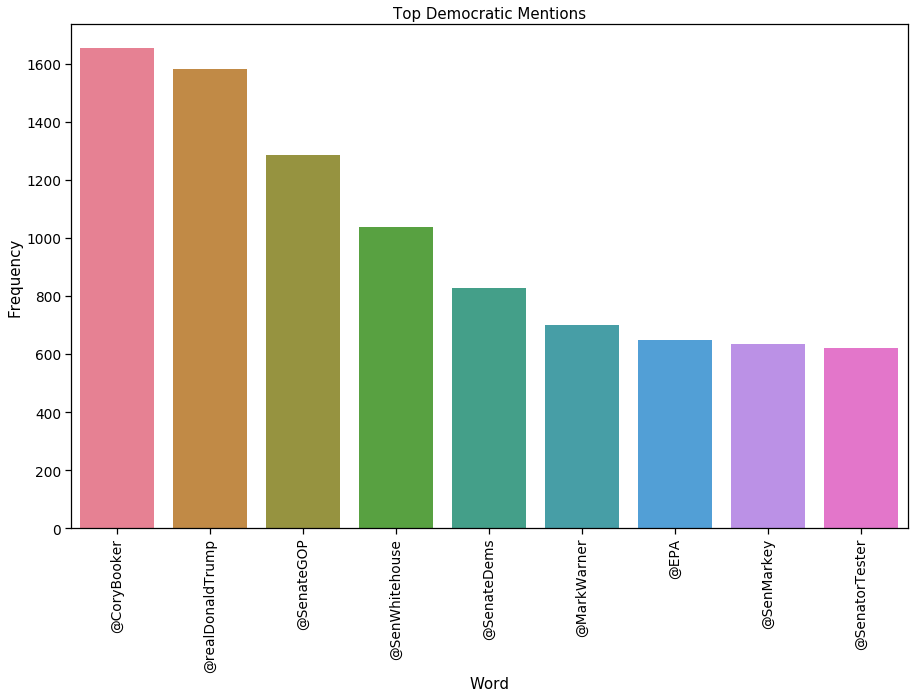

In [26]:
topwords = dmentioned.most_common()[1:10]
words = [w[0] for w in topwords]
counts = [w[1] for w in topwords]
x_pos = np.arange(len(words))

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='Top Democratic Mentions')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='husl')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

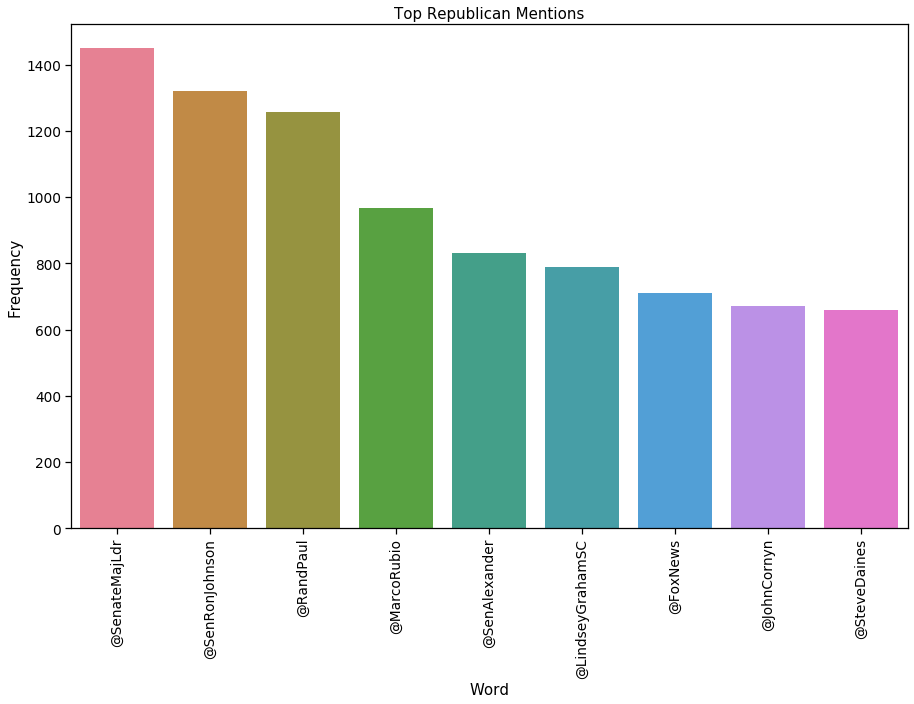

In [27]:
topwords = rmentioned.most_common()[1:10]
words = [w[0] for w in topwords]
counts = [w[1] for w in topwords]
x_pos = np.arange(len(words))

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='Top Republican Mentions')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='husl')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

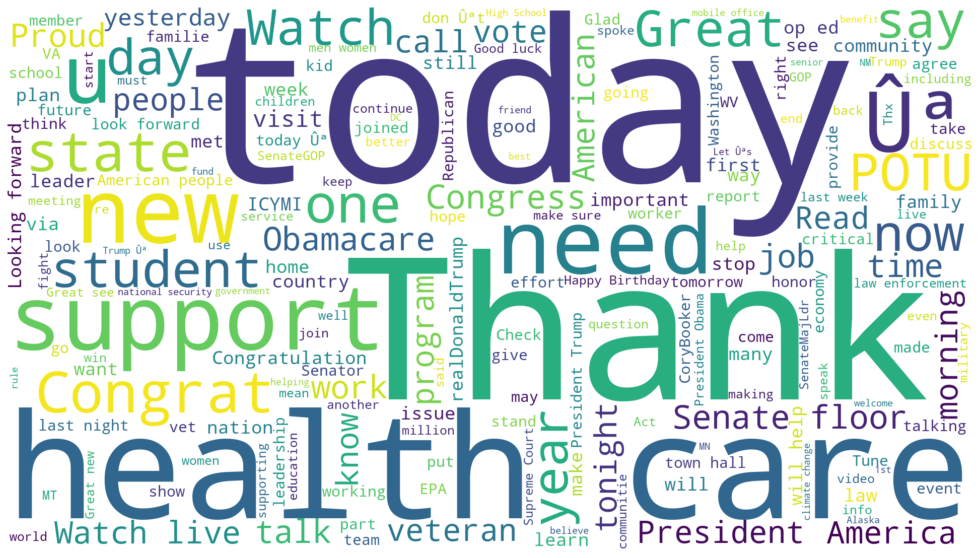

In [28]:
# Generating a wordcloud

text = " ".join(tweet for tweet in df['Clean text'])

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["https", "co", "U", "RT", "u","û","Ûù","Ò","ò","Û_","Û","ÛÒ","Ûa","ÛÓ","ûa","Û a","Ûa ","a"])

# Generate a word cloud image
wordcloud = WordCloud(width=1920, height=1080,stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Method 1: Predicting political party based on tweet

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import confusion_matrix

In [31]:
tfidf = TfidfVectorizer(stop_words='english',max_features=10000)

In [50]:
# Vectorizing the tweets
tweet = df['Clean text']
tweettfidf = tfidf.fit_transform(tweet)
positiveEngagement = coo_matrix(df['favorites']/df['retweets'])


In [13]:
df['ratio'] = df['replies']/(df['favorites'] + 1)
df['logfavorites'] = np.log(df['favorites'] + 1)
df['party'] = df.apply(lambda x: "D" if x['party'] == "I" else x['party'], axis = 1)

GroupUser = df.groupby(['user'], as_index=False)['logfavorites'].agg(['min','max']).reset_index()
df = pd.merge(df,GroupUser, how = 'inner', on = 'user')
df['likenorm'] = (df['logfavorites'] - df['min'])/(df['max'] - df['min'])
df.drop(['min', 'max'], axis = 1, inplace = True)


tfidf = TfidfVectorizer(max_features=10000,stop_words='english')
df_tfidf = tfidf.fit_transform(df['Clean text'])
pos = np.array(df['likenorm'].tolist())
neg = df['ratio'].tolist()
size = len(pos)
df_tfidf = hstack([df_tfidf,np.reshape(np.array(pos),(size,1)),np.reshape(np.array(neg),(size,1))])

In [37]:
# Split the data into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(df_tfidf,df['party'].tolist(), test_size=0.2, random_state=40)

In [38]:
# Label encoder for the y values
enc = LabelEncoder()
ytrain = enc.fit_transform(ytrain)
ytest = enc.fit_transform(ytest)

In [168]:
enc.classes_

array(['D', 'R'], dtype='<U1')

In [202]:
# Use Tfidf and Multinomial Naive Bayes to build a prediction model

# xtrain_tfidf = tfidf.fit_transform(xtrain)
# xval_tfidf = tfidf.transform(xtest)

clf = MultinomialNB()

clf.fit(xtrain, ytrain)
pred = clf.predict(xtest)

In [203]:
print("The accuracy of the Multinomial NB model is {:.2f}%".format(f1_score(ytest, pred, average="micro")*100))

The accuracy of the Multinomial NB model is 83.92%


[[24062  4205]
 [ 5075 24381]]


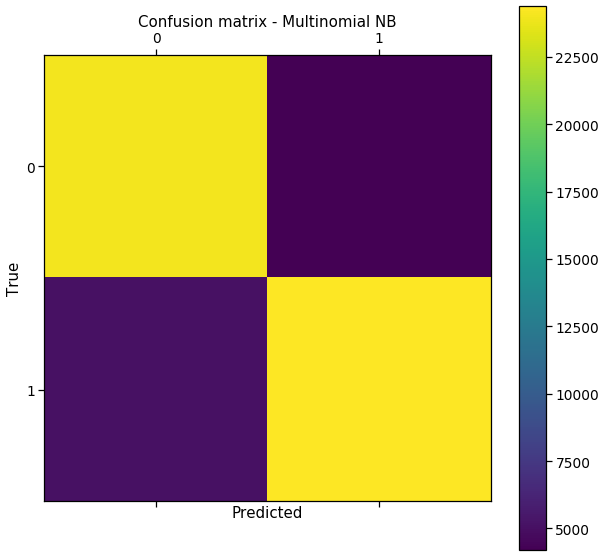

In [201]:


# confusion_matrix(ytest,pred)

labels = [0,1]
cm = confusion_matrix(ytest, pred, labels)
print(cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix - Multinomial NB')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [207]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1',random_state=40, solver='liblinear', C=4).fit(xtrain, ytrain)
pred = clf.predict(xtest)


In [196]:
print("The accuracy of the Lasso model is {:.2f}%".format(f1_score(ytest, pred, average="micro")*100))

The accuracy of the Lasso model is 85.33%


[[23988  4279]
 [ 4190 25266]]


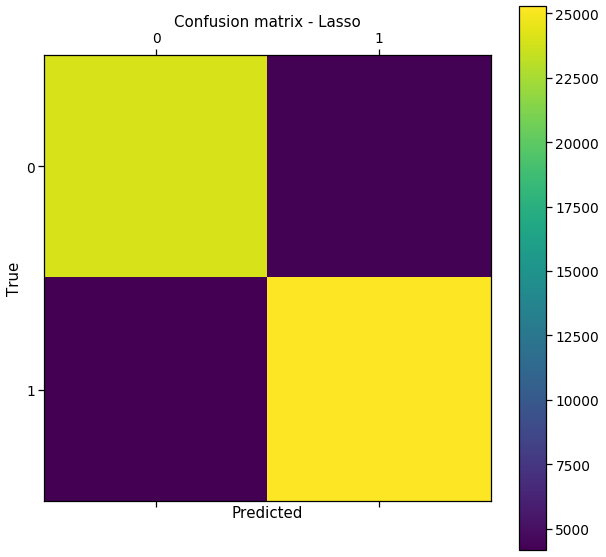

In [197]:
labels = [0,1]
cm = confusion_matrix(ytest, pred, labels)
print(cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix - Lasso')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [193]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = 25,random_state=40, n_estimators = 250, min_samples_split = 10).fit(xtrain,ytrain)
pred = clf.predict(xtest)

print("The accuracy of the Random Forest model is {:.2f}%".format(f1_score(ytest, pred, average="micro")*100))

The accuracy of the Random Forest model is 76.72%


[[19504  8763]
 [ 4676 24780]]


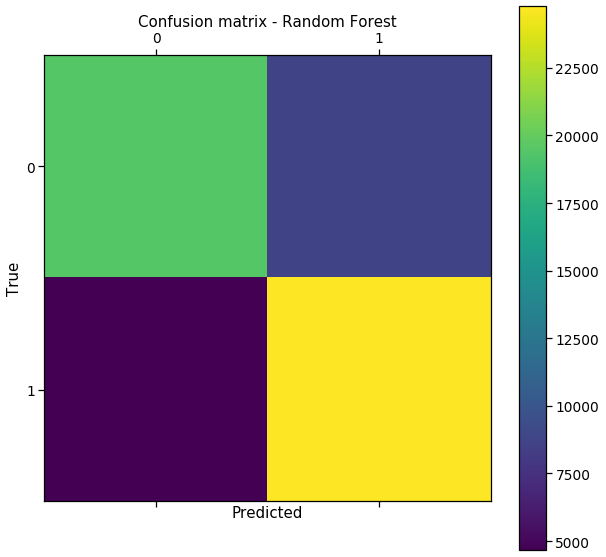

In [194]:
labels = [0,1]
cm = confusion_matrix(ytest, pred, labels)
print(cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix - Random Forest')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [146]:
# Top features

maxcoeffs = clf.coef_.argsort()[-3:][::-1][0]
maxcoeffvals = clf.coef_
maxcoeffvals = np.sort(maxcoeffvals)[0][::-1]


features = tfidf.get_feature_names()
features
maxcoeffs = maxcoeffs[:20]
x = []
y = []
for i in range(0,len(maxcoeffs)):
    x.append(features[maxcoeffs[i]])
    y.append(maxcoeffvals[i])


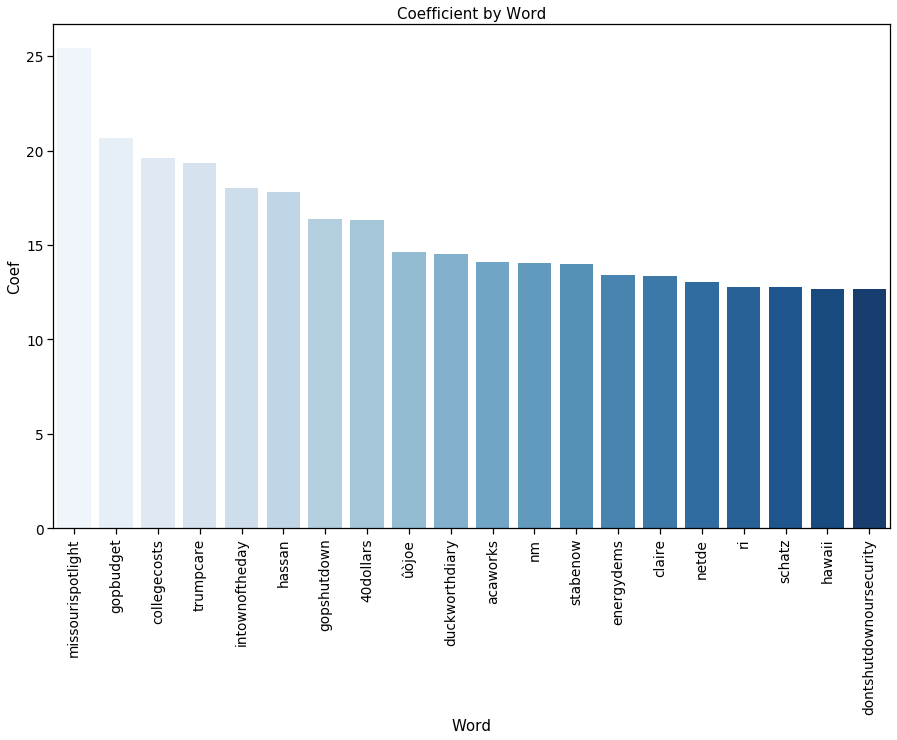

In [150]:
x_pos = np.arange(len(maxcoeffs))

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='Coefficient by Word')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, y, palette='Blues')
plt.xticks(x_pos, x, rotation=90) 
plt.xlabel('Word')
plt.ylabel('Coef')
plt.show()

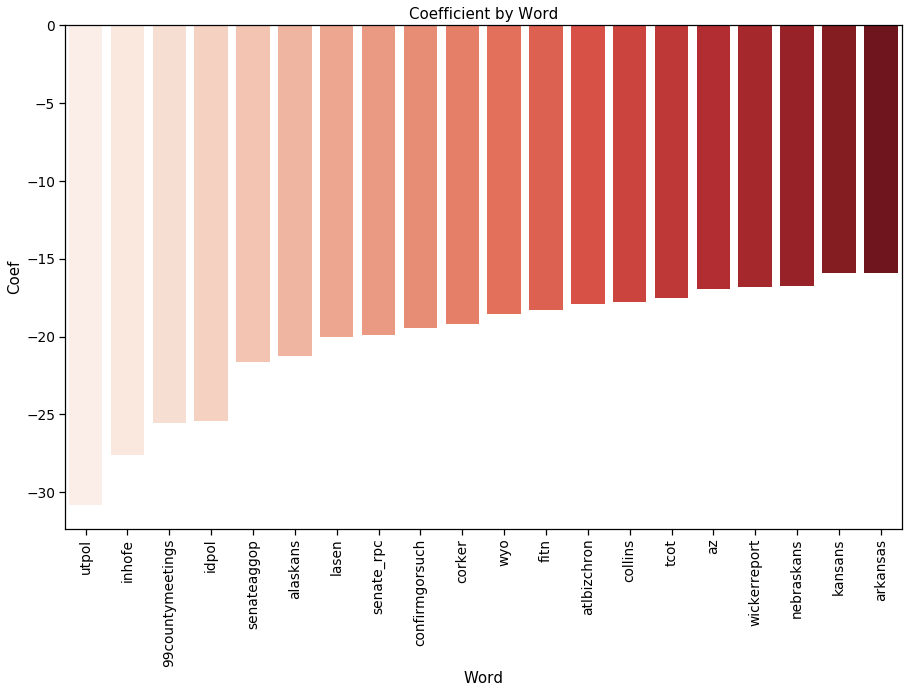

In [208]:
maxcoeffs = clf.coef_.argsort()[-3:][::-1][0]
maxcoeffs = maxcoeffs[-20:][::-1]
maxcoeffvals = clf.coef_
maxcoeffvals = np.sort(maxcoeffvals)[0]
x = []
y = []
for i in range(0,len(maxcoeffs)):
    x.append(features[maxcoeffs[i]])
    y.append(maxcoeffvals[i])
    
x_pos = np.arange(len(maxcoeffs))

plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='Coefficient by Word')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, y, palette='Reds')
plt.xticks(x_pos, x, rotation=90) 
plt.xlabel('Word')
plt.ylabel('Coef')
plt.show()

In [157]:
maxcoeffs

array([5729, 3891, 1884, 9182, 4716, 4142, 3899,  181, 9970, 2865,  364,
       6070, 8450, 3062, 1761, 6009, 7568, 7829, 4152, 2791])

In [66]:
tfidf.inverse_transform(a[:,9436])

[array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], dtype='<U26'),
 array([], d

In [69]:
tfidf.get_feature_names()[9436]

'utpol'

In [ ]:
# Testing a sample

# Taken from a recent Trump tweet
sampletweet = 'The 2020 Election will be totally rigged if Mail-In Voting is allowed to take place, & everyone knows it. So much time is taken talking about foreign influence, but the same people won’t even discuss Mail-In election corruption. Look at Patterson, N.J. 20% of vote was corrupted!'

def predictTweet(tweet):
    tfidftransform = tfidf.transform([tweet])
    prediction = clf.predict(tfidftransform)
    politicalparty = enc.inverse_transform(prediction)
    return politicalparty[0]

predictTweet(sampletweet)
predictTweet('Because of my strong focus on the China Virus, including scheduled meetings on Vaccines, our economy and much else, I won’t be able to be in New York to throw out the opening pitch for the @Yankees on August 15th. We will make it later in the season!')


# Method 2: Predicting engagement (retweets) based on tweet

In [92]:
tfidf = TfidfVectorizer(ngram_range=(2,3),stop_words=stopwords)

In [95]:
xtfidf = tfidf.fit_transform(X)

In [98]:
c = np.hstack((xtfidf,b))

In [101]:
c

array([<288615x3128792 sparse matrix of type '<class 'numpy.float64'>'
	with 4885579 stored elements in Compressed Sparse Row format>,
       4.131782945736434, 3.260869565217391, ..., 0.0, 0.2,
       1.3076923076923077], dtype=object)

In [82]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy.sparse import hstack

# Split the data into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(c,(df['favorites']/df['retweets']).tolist(), test_size=0.2, random_state=40)

In [29]:
enc = LabelEncoder()
ytrain = enc.fit_transform(ytrain)
ytest = enc.fit_transform(ytest)

In [21]:
# Use Tfidf and ridge regression
tfidf = TfidfVectorizer(ngram_range=2)

xtrain_tfidf = tfidf.fit_transform(xtrain)
xval_tfidf = tfidf.transform(xtest)

ridgeclf = Ridge()
lassoclf = Lasso(alpha=0.1)


ridgeclf.fit(xtrain_tfidf, ytrain)
lassoclf.fit(xtrain_tfidf, ytrain)

predridge = ridgeclf.predict(xval_tfidf)
predlasso = lassoclf.predict(xval_tfidf)

In [22]:
ridgeclf.score(xval_tfidf,ytest)

-6.1516789182804255